## Modeling multiple input triples 

In this document, I will model triples with multiple inputs. I begin by preparing the data, as I need unique names for entities and relations. Then I move on to the models. I decided to use the **[RESCAL](https://icml.cc/2011/papers/438_icmlpaper.pdf)** and **[ConvE](https://ojs.aaai.org/index.php/AAAI/article/view/11573)** models. That being said, each of them will have its own section, beginning with an example of a model with basic settings using the `pipeline()` function from the [PyKeen](https://pykeen.readthedocs.io/en/stable/index.html) package. Then, using the same package's `hpo_pipeline()`, I tune the hyperparameters. Finally, I build the final model with the best parameters, make some predictions, and evaluate it. 



In [25]:
# for loding and saving the files 
import pickle 
import os 

# creating unique names 
import pandas as pd
import numpy as np
import re

# splitting the data into training, testing, validation
from sklearn.model_selection import train_test_split

# PyKeen packages 
from pykeen.triples import TriplesFactory
from pykeen.models import RESCAL
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen.hpo import hpo_pipeline
from pykeen import predict

# for emmbeding visualisation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go



---

## 1. Data preapration

In this section, I need to give the entities and relations 'unique' names. In the case of multiple inputs in one triple I will combine the names of the inputs into one and remove the '&' between them. Moreover, I will remove the spaces between the output names. As a result, triples instead of looking like this:

```
([('ObjectQ, VectorTessellationA, NominalA') & ('FieldQ, VectorTessellationA, PlainNominalA')], 'IntersectDissolveField2Object', 'ObjectQ, VectorRegionA, ERA'))
```

Therefore, they will look like this:

```
('ObjectQVectorTessellationANominalAFieldQVectorTessellationAPlainNominalA', 'IntersectDissolveField2Object', 'ObjectQVectorRegionAERA')
```


In [26]:
# loading the file 

# indicating the directory where the file is located  
directory_triples = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/triples"
os.chdir(directory_triples)

# opening the picke file with the triples 
with open('triples_multiple_df.pkl', 'rb') as file:
    triples_multiple_df = pickle.load(file)
    
# showing the data frame 
triples_multiple_df

head  \
0    ObjectQ, VectorTessellationA, NominalA & Field...   
1    ObjectQ, VectorTessellationA, NominalA & Objec...   
2    ObjectQ, VectorTessellationA, PlainIntervalA &...   
3    ObjectQ, PlainVectorRegionA, PlainOrdinalA & F...   
4    ObjectQ, PlainVectorRegionA, PlainIntervalA & ...   
..                                                 ...   
215  ObjectQ, PlainVectorRegionA, OrdinalA & FieldQ...   
216  ObjectQ, PlainVectorRegionA, NominalA & FieldQ...   
217  ObjectQ, PlainVectorRegionA, NominalA & FieldQ...   
218  ObjectQ, PlainVectorRegionA, NominalA & FieldQ...   
219  ObjectQ, PlainVectorRegionA, PlainNominalA & F...   

                          relation                               tail  
0    IntersectDissolveField2Object        ObjectQ, VectorRegionA, ERA  
1          SpatialJoinSumTessRatio  ObjectQ, VectorTessellationA, ERA  
2          SpatialJoinSumTessRatio  ObjectQ, VectorTessellationA, ERA  
3          ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
4          ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
..                             ...                                ...  
215        ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
216        ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
217        ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
218        ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
219        ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  

[220 rows x 3 columns]

In [27]:
# get values of heads 
values_head = triples_multiple_df['head']

# get values of tails 
values_tail = triples_multiple_df['tail']


# create a dictionary to map unique values to unique names for head 
unique_names_head = {value: ''.join(re.findall(r'[A-Z]+[a-z]*', str(value))) for value in values_head}

# Create a dictionary to map unique values to unique names for tail 
unique_names_tail = {value: ''.join(re.findall(r'[A-Z]+[a-z]*', str(value))) for value in values_tail}

#create df with unique values 
unique_df = triples_multiple_df

# Replace the values in the 'head' column with the unique names
unique_df['head'] = unique_df['head'].apply(str).replace(unique_names_head)

# Replace the values in the 'tail' column with the unique names 
unique_df['tail'] = unique_df['tail'].apply(str).replace(unique_names_tail)

unique_df

head  \
0    ObjectQVectorTessellationANominalAFieldQVector...   
1    ObjectQVectorTessellationANominalAObjectQVecto...   
2    ObjectQVectorTessellationAPlainIntervalAObject...   
3    ObjectQPlainVectorRegionAPlainOrdinalAFieldQRa...   
4    ObjectQPlainVectorRegionAPlainIntervalAFieldQR...   
..                                                 ...   
215  ObjectQPlainVectorRegionAOrdinalAFieldQRasterA...   
216  ObjectQPlainVectorRegionANominalAFieldQRasterA...   
217  ObjectQPlainVectorRegionANominalAFieldQRasterA...   
218  ObjectQPlainVectorRegionANominalAFieldQRasterA...   
219  ObjectQPlainVectorRegionAPlainNominalAFieldQRa...   

                          relation                           tail  
0    IntersectDissolveField2Object        ObjectQVectorRegionAERA  
1          SpatialJoinSumTessRatio  ObjectQVectorTessellationAERA  
2          SpatialJoinSumTessRatio  ObjectQVectorTessellationAERA  
3          ZonalStatisticsSumField   ObjectQPlainVectorRegionAERA  
4          ZonalStatisticsSumField   ObjectQPlainVectorRegionAERA  
..                             ...                            ...  
215        ZonalStatisticsSumField   ObjectQPlainVectorRegionAERA  
216        ZonalStatisticsSumField   ObjectQPlainVectorRegionAERA  
217        ZonalStatisticsSumField   ObjectQPlainVectorRegionAERA  
218        ZonalStatisticsSumField   ObjectQPlainVectorRegionAERA  
219        ZonalStatisticsSumField   ObjectQPlainVectorRegionAERA  

[220 rows x 3 columns]

The next step is to divide the data into training, validation and testing data sets. To do that I used **[sklearn](https://scikit-learn.org/stable/)** library. 

In [28]:
factory_multiple = TriplesFactory.from_labeled_triples(unique_df[["head", "relation", "tail"]].astype(str).values)
factory_multiple

TriplesFactory(num_entities=132, num_relations=20, create_inverse_triples=False, num_triples=125)

In [29]:
random_seed = 42
test_size = 0.1  # percentage of triples for testing
val_size = 0.1  # percentage of triples for validation

# splitting the triples into training and the rest 
train_triples, remaining_triples = train_test_split(factory_multiple.mapped_triples, test_size=test_size+val_size, random_state=random_seed)

# splitting the rest triples into test and validation sets 
test_triples, val_triples = train_test_split(remaining_triples, test_size=val_size/(test_size+val_size), random_state=random_seed)

# extracting entity_to_id and relation_to_id mappings 
entity_to_id = factory_multiple.entity_to_id
relation_to_id = factory_multiple.relation_to_id

# creating factories for each split
training_factory = TriplesFactory(train_triples, entity_to_id, relation_to_id)
testing_factory = TriplesFactory(test_triples, entity_to_id, relation_to_id)
validation_factory = TriplesFactory(val_triples, entity_to_id, relation_to_id)

In [75]:
training_factory

TriplesFactory(num_entities=132, num_relations=20, create_inverse_triples=False, num_triples=100)

In [76]:
testing_factory

TriplesFactory(num_entities=132, num_relations=20, create_inverse_triples=False, num_triples=12)

In [77]:
validation_factory

TriplesFactory(num_entities=132, num_relations=20, create_inverse_triples=False, num_triples=13)

---

## 2. RESCAL model

This section consists of an example of the basic RESCAL model, the hyperparameter tuning for it and later the evaluation with the example of prediction.

### 2.1 RESCAL model - simple example 

Now, I'll create an example model with basic parameters just to see how it works befor tuning. However, I will not go into too much detail about it in the paper. This step only serves to demonstrate whether or not the hyperparameter tuning improved the model.



In [123]:
# generating the first model 
model_multiple_basic = pipeline(
    training=training_factory,
    testing=testing_factory,
    validation = validation_factory, 
    model= "RESCAL",
    training_loop = "slcwa",
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,    
    ),
    random_seed=42)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/12.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


In [40]:
# setting directory to save the model and all its parameters 
dir_model_multiple = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_RESCAL"

In [33]:

# saving the model_multiple_basic
model_multiple_basic.save_to_directory(dir_model_multiple)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=132, num_relations=20, create_inverse_triples=False, num_triples=100) to file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

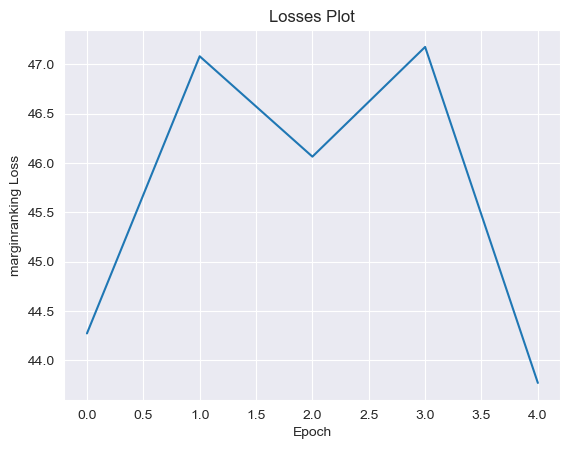

In [125]:
model_multiple_basic.plot_losses()

### 2.2 RESCAL model - hyperparameter tuning

In this section, I tune the RESCAL model's hyperparameters. Some of the intervals for which the parameters are tuned were taken from the Pykeen website and adjusted to the size of the data set, and the `hpo_pipeline()` automatically tunes for them in some cases. Then I take the best parameters produced and apply them to the standard pipeline. 



In [38]:
hpo_pipeline_result = hpo_pipeline(
    n_trials=30,
    training=training_factory,
    testing=testing_factory,
    validation = validation_factory, 
    model= "RESCAL",
    lr_scheduler='ExponentialLR',
    lr_scheduler_kwargs_ranges=dict(
        gamma=dict(type=float, low=0.8, high=1.0),
    ),
    training_loop = "slcwa",
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,    
    )    
)

[I 2023-06-15 23:07:39,942] A new study created in memory with name: no-name-406f22c4-492e-4fcb-9c30-d753f6af06a9
INFO:pykeen.hpo.hpo:Using model: <class 'pykeen.models.unimodal.rescal.RESCAL'>
INFO:pykeen.hpo.hpo:Using loss: <class 'pykeen.losses.MarginRankingLoss'>
INFO:pykeen.hpo.hpo:Using regularizer: <class 'pykeen.regularizers.LpRegularizer'>
INFO:pykeen.hpo.hpo:Using optimizer: <class 'torch.optim.adam.Adam'>
INFO:pykeen.hpo.hpo:Using lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
INFO:pykeen.hpo.hpo:Using training loop: <class 'pykeen.training.slcwa.SLCWATrainingLoop'>
INFO:pykeen.hpo.hpo:Using negative sampler: <class 'pykeen.sampling.basic_negative_sampler.BasicNegativeSampler'>
INFO:pykeen.hpo.hpo:Using evaluator: <class 'pykeen.evaluation.rank_based_evaluator.RankBasedEvaluator'>
INFO:pykeen.hpo.hpo:Attempting to maximize both.realistic.inverse_harmonic_mean_rank
INFO:pykeen.hpo.hpo:Filter validation triples when testing: True
INFO:pykeen.pipeline.api:Using 

Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

c:\Users\wlibe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:08:09,610] Trial 0 finished with value: 0.18042388558387756 and parameters: {'model.embedding_dim': 128, 'loss.margin': 1.940499111755171, 'regularizer.weight': 0.18558743042845458, 'optimizer.lr': 0.085165366131444, 'lr_scheduler.gamma': 0.9127021193300726, 'negative_sampler.num_negs_per_pos': 2, 'training.num_epochs': 200, 'training.batch_size': 64}. Best is trial 0 with value: 0.18042388558387756.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:08:46,011] Trial 1 finished with value: 0.24382689595222473 and parameters: {'model.embedding_dim': 144, 'loss.margin': 0.7849048099676473, 'regularizer.weight': 0.08207979024990086, 'optimizer.lr': 0.011645510353082134, 'lr_scheduler.gamma': 0.802451401015117, 'negative_sampler.num_negs_per_pos': 7, 'training.num_epochs': 200, 'training.batch_size': 2048}. Best is trial 1 with value: 0.24382689595222473.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-15 23:11:39,325] Trial 2 finished with value: 0.3101603388786316 and parameters: {'model.embedding_dim': 224, 'loss.margin': 2.1085724203363956, 'regularizer.weight': 0.7561993302092093, 'optimizer.lr': 0.06291089648064307, 'lr_scheduler.gamma': 0.840390183530002, 'negative_sampler.num_negs_per_pos': 32, 'training.num_epochs': 200, 'training.batch_size': 512}. Best is trial 2 with value: 0.3101603388786316.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:15:16,644] Trial 3 finished with value: 0.4019279778003692 and parameters: {'model.embedding_dim': 96, 'loss.margin': 0.48691386419932026, 'regularizer.weight': 0.7122801470403856, 'optimizer.lr': 0.011707511964956608, 'lr_scheduler.gamma': 0.9303170378395301, 'negative_sampler.num_negs_per_pos': 13, 'training.num_epochs': 1000, 'training.batch_size': 32}. Best is trial 3 with value: 0.4019279778003692.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:17:41,896] Trial 4 finished with value: 0.24581196904182434 and parameters: {'model.embedding_dim': 144, 'loss.margin': 0.1465188122296932, 'regularizer.weight': 0.7763588987913201, 'optimizer.lr': 0.029344891537701513, 'lr_scheduler.gamma': 0.898721723228953, 'negative_sampler.num_negs_per_pos': 2, 'training.num_epochs': 800, 'training.batch_size': 1024}. Best is trial 3 with value: 0.4019279778003692.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/600 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:20:44,970] Trial 5 finished with value: 0.2815362513065338 and parameters: {'model.embedding_dim': 240, 'loss.margin': 2.183743934690433, 'regularizer.weight': 0.6546441452459815, 'optimizer.lr': 0.019334260598767007, 'lr_scheduler.gamma': 0.8046996678096281, 'negative_sampler.num_negs_per_pos': 4, 'training.num_epochs': 600, 'training.batch_size': 256}. Best is trial 3 with value: 0.4019279778003692.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds
[I 2023-06-15 23:22:06,156] Trial 6 finished with value: 0.4500999748706818 and parameters: {'model.embedding_dim': 208, 'loss.margin': 0.12957505730323104, 'regularizer.weight': 0.247158819429737, 'optimizer.lr': 0.02947357669582584, 'lr_scheduler.gamma': 0.890543707185229, 'negative_sampler.num_negs_per_pos': 28, 'training.num_epochs': 100, 'training.batch_size': 32}. Best is trial 6 with value: 0.4500999748706818.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:30:03,866] Trial 7 finished with value: 0.2841438055038452 and parameters: {'model.embedding_dim': 208, 'loss.margin': 0.5762353742867437, 'regularizer.weight': 0.882401092545167, 'optimizer.lr': 0.009951352867409068, 'lr_scheduler.gamma': 0.9841774862498032, 'negative_sampler.num_negs_per_pos': 10, 'training.num_epochs': 1000, 'training.batch_size': 32}. Best is trial 6 with value: 0.4500999748706818.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-15 23:32:37,401] Trial 8 finished with value: 0.4660466015338897 and parameters: {'model.embedding_dim': 192, 'loss.margin': 0.749652931499351, 'regularizer.weight': 0.9539867667296074, 'optimizer.lr': 0.01644073327435831, 'lr_scheduler.gamma': 0.9411527367158932, 'negative_sampler.num_negs_per_pos': 72, 'training.num_epochs': 100, 'training.batch_size': 64}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/400 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:35:23,956] Trial 9 finished with value: 0.02489505521953106 and parameters: {'model.embedding_dim': 144, 'loss.margin': 2.3315358118248843, 'regularizer.weight': 0.8182892836223918, 'optimizer.lr': 0.09394462393719652, 'lr_scheduler.gamma': 0.953913091931352, 'negative_sampler.num_negs_per_pos': 28, 'training.num_epochs': 400, 'training.batch_size': 32}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:37:33,731] Trial 10 finished with value: 0.09719813615083694 and parameters: {'model.embedding_dim': 32, 'loss.margin': 1.2588442790951198, 'regularizer.weight': 0.9662051918791121, 'optimizer.lr': 0.05149309688973297, 'lr_scheduler.gamma': 0.9960822787083798, 'negative_sampler.num_negs_per_pos': 60, 'training.num_epochs': 500, 'training.batch_size': 64}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:41:08,643] Trial 11 finished with value: 0.3283044099807739 and parameters: {'model.embedding_dim': 192, 'loss.margin': 2.997388801511598, 'regularizer.weight': 0.4021955492942807, 'optimizer.lr': 0.03219657139625045, 'lr_scheduler.gamma': 0.8806606101286398, 'negative_sampler.num_negs_per_pos': 100, 'training.num_epochs': 100, 'training.batch_size': 16}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/400 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:47:57,359] Trial 12 finished with value: 0.3378557860851288 and parameters: {'model.embedding_dim': 256, 'loss.margin': 0.0014632522964410088, 'regularizer.weight': 0.4939366036485626, 'optimizer.lr': 0.0023883140177569095, 'lr_scheduler.gamma': 0.9452267196302796, 'negative_sampler.num_negs_per_pos': 29, 'training.num_epochs': 400, 'training.batch_size': 128}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-15 23:51:10,838] Trial 13 finished with value: 0.41802772879600525 and parameters: {'model.embedding_dim': 192, 'loss.margin': 1.0215009836752325, 'regularizer.weight': 0.9985971251910926, 'optimizer.lr': 0.03341049268096062, 'lr_scheduler.gamma': 0.878033536938643, 'negative_sampler.num_negs_per_pos': 88, 'training.num_epochs': 100, 'training.batch_size': 4096}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/7 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:55:01,233] Trial 14 finished with value: 0.010732592083513737 and parameters: {'model.embedding_dim': 176, 'loss.margin': 0.5260647298670917, 'regularizer.weight': 0.31619245637194027, 'optimizer.lr': 0.04290631443563543, 'lr_scheduler.gamma': 0.962561380904518, 'negative_sampler.num_negs_per_pos': 53, 'training.num_epochs': 300, 'training.batch_size': 16}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:58:48,037] Trial 15 finished with value: 0.33268988132476807 and parameters: {'model.embedding_dim': 96, 'loss.margin': 0.9761045853414352, 'regularizer.weight': 0.6082943583289657, 'optimizer.lr': 0.02262403133525904, 'lr_scheduler.gamma': 0.919124809557567, 'negative_sampler.num_negs_per_pos': 17, 'training.num_epochs': 700, 'training.batch_size': 64}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-15 23:59:17,685] Trial 16 finished with value: 0.331128865480423 and parameters: {'model.embedding_dim': 176, 'loss.margin': 0.23219764567270307, 'regularizer.weight': 0.5460833981372112, 'optimizer.lr': 0.04192768507522429, 'lr_scheduler.gamma': 0.8904357091284052, 'negative_sampler.num_negs_per_pos': 1, 'training.num_epochs': 100, 'training.batch_size': 4096}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
[I 2023-06-16 00:05:22,845] Trial 17 finished with value: 0.12557019293308258 and parameters: {'model.embedding_dim': 224, 'loss.margin': 1.377154087779299, 'regularizer.weight': 0.29116113610765215, 'optimizer.lr': 0.0013683770954620207, 'lr_scheduler.gamma': 0.9317213350012975, 'negative_sampler.num_negs_per_pos': 42, 'training.num_epochs': 300, 'training.batch_size': 512}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-16 00:06:49,781] Trial 18 finished with value: 0.30573251843452454 and parameters: {'model.embedding_dim': 32, 'loss.margin': 0.32468893645691393, 'regularizer.weight': 0.4590537244727535, 'optimizer.lr': 0.021850438783571735, 'lr_scheduler.gamma': 0.8619380761118901, 'negative_sampler.num_negs_per_pos': 19, 'training.num_epochs': 300, 'training.batch_size': 1024}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds
[I 2023-06-16 00:22:57,705] Trial 19 finished with value: 0.4214398264884949 and parameters: {'model.embedding_dim': 256, 'loss.margin': 0.7692802569145729, 'regularizer.weight': 0.025087639575995746, 'optimizer.lr': 0.06524375427934136, 'lr_scheduler.gamma': 0.918196793878413, 'negative_sampler.num_negs_per_pos': 62, 'training.num_epochs': 500, 'training.batch_size': 256}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-16 00:23:34,656] Trial 20 finished with value: 0.4062865972518921 and parameters: {'model.embedding_dim': 96, 'loss.margin': 0.12976092651174045, 'regularizer.weight': 0.5741656755355187, 'optimizer.lr': 0.024976456411400113, 'lr_scheduler.gamma': 0.9697690284494914, 'negative_sampler.num_negs_per_pos': 24, 'training.num_epochs': 100, 'training.batch_size': 128}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-16 00:49:01,470] Trial 21 finished with value: 0.44041782617568964 and parameters: {'model.embedding_dim': 256, 'loss.margin': 0.7665753839027798, 'regularizer.weight': 0.04692648286269871, 'optimizer.lr': 0.0657855630195147, 'lr_scheduler.gamma': 0.9038797212824072, 'negative_sampler.num_negs_per_pos': 62, 'training.num_epochs': 800, 'training.batch_size': 256}. Best is trial 8 with value: 0.4660466015338897.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-16 01:06:41,147] Trial 22 finished with value: 0.4851817488670349 and parameters: {'model.embedding_dim': 224, 'loss.margin': 0.4253524417122581, 'regularizer.weight': 0.12757147501718147, 'optimizer.lr': 0.05735616353146479, 'lr_scheduler.gamma': 0.9028213169378085, 'negative_sampler.num_negs_per_pos': 44, 'training.num_epochs': 800, 'training.batch_size': 256}. Best is trial 22 with value: 0.4851817488670349.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-16 01:24:44,970] Trial 23 finished with value: 0.44808816909790034 and parameters: {'model.embedding_dim': 208, 'loss.margin': 0.36918264492080877, 'regularizer.weight': 0.1469926137144452, 'optimizer.lr': 0.03707817642936318, 'lr_scheduler.gamma': 0.9401827494838128, 'negative_sampler.num_negs_per_pos': 39, 'training.num_epochs': 900, 'training.batch_size': 32}. Best is trial 22 with value: 0.4851817488670349.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-16 01:32:33,822] Trial 24 finished with value: 0.3890603482723236 and parameters: {'model.embedding_dim': 176, 'loss.margin': 0.34193063677397134, 'regularizer.weight': 0.21758531537990747, 'optimizer.lr': 0.04917883134849744, 'lr_scheduler.gamma': 0.9280109284422203, 'negative_sampler.num_negs_per_pos': 38, 'training.num_epochs': 700, 'training.batch_size': 2048}. Best is trial 22 with value: 0.4851817488670349.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
[I 2023-06-16 01:43:24,130] Trial 25 finished with value: 0.48528847098350525 and parameters: {'model.embedding_dim': 224, 'loss.margin': 0.060331338980165405, 'regularizer.weight': 0.3728805314484027, 'optimizer.lr': 0.029460582946939592, 'lr_scheduler.gamma': 0.905424755395583, 'negative_sampler.num_negs_per_pos': 21, 'training.num_epochs': 700, 'training.batch_size': 256}. Best is trial 25 with value: 0.48528847098350525.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-16 01:52:39,619] Trial 26 finished with value: 0.4275074005126953 and parameters: {'model.embedding_dim': 224, 'loss.margin': 0.6484133228482732, 'regularizer.weight': 0.3613211520512808, 'optimizer.lr': 0.018923396428707932, 'lr_scheduler.gamma': 0.911656183517789, 'negative_sampler.num_negs_per_pos': 17, 'training.num_epochs': 700, 'training.batch_size': 256}. Best is trial 25 with value: 0.48528847098350525.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds
[I 2023-06-16 02:24:16,350] Trial 27 finished with value: 0.5045444965362549 and parameters: {'model.embedding_dim': 240, 'loss.margin': 0.44486940248176415, 'regularizer.weight': 0.3932254214904536, 'optimizer.lr': 0.037833961058865585, 'lr_scheduler.gamma': 0.9444785118171812, 'negative_sampler.num_negs_per_pos': 82, 'training.num_epochs': 800, 'training.batch_size': 256}. Best is trial 27 with value: 0.5045444965362549.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-16 02:48:11,029] Trial 28 finished with value: 0.42810139060020447 and parameters: {'model.embedding_dim': 240, 'loss.margin': 0.4158077575062798, 'regularizer.weight': 0.4200555568703744, 'optimizer.lr': 0.052308662184580176, 'lr_scheduler.gamma': 0.9506139538412723, 'negative_sampler.num_negs_per_pos': 48, 'training.num_epochs': 900, 'training.batch_size': 256}. Best is trial 27 with value: 0.5045444965362549.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
[I 2023-06-16 03:28:33,651] Trial 29 finished with value: 0.5044499635696411 and parameters: {'model.embedding_dim': 240, 'loss.margin': 0.03505981058346608, 'regularizer.weight': 0.1757922439137418, 'optimizer.lr': 0.07329369627713808, 'lr_scheduler.gamma': 0.9107696484235499, 'negative_sampler.num_negs_per_pos': 100, 'training.num_epochs': 800, 'training.batch_size': 256}. Best is trial 27 with value: 0.5045444965362549.


In [39]:
# saving the results to the directory 
hpo_pipeline_result.save_to_directory(dir_model_multiple)

There is a function `replicate _best_pipeline()`, however it does not work well on custom datasets like this one. Therefore, I will just take the parameters form the 'best_pipeline' folder that was created by saving the model and apply them in `piepline()` manually. 

In [64]:
#making the model with the best parameters 

final_model_RESCAL = pipeline(
    evaluator= "rankbased",
    filter_validation_when_testing = True,
    loss= "marginranking",
    loss_kwargs= dict(margin = 0.44486940248176415),
    lr_scheduler= "exponential",
    lr_scheduler_kwargs =dict(
        gamma =0.9444785118171812),
    model= "rescal",
    model_kwargs= dict(
        embedding_dim = 240),
    negative_sampler= "basic",
    negative_sampler_kwargs= dict(
        filtered = True, 
        num_negs_per_pos = 82),
    optimizer= "adam",
    optimizer_kwargs= dict(
        lr= 0.037833961058865585),
    regularizer= "lp",
    regularizer_kwargs= dict(
        weight= 0.3932254214904536),
    testing = testing_factory,
    training= training_factory,
    training_kwargs= dict(
        batch_size = 256,
        num_epochs = 800),
    training_loop ="slcwa",
    validation= validation_factory,
    use_testing_data = True, 
    random_seed=42  
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

c:\Users\wlibe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/12.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


### 2.3 RESCAL model - evaluation and prediction

This section is dedicated to reading the evaluation of the model as well as predicting some of the examples to see how the model did.

<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

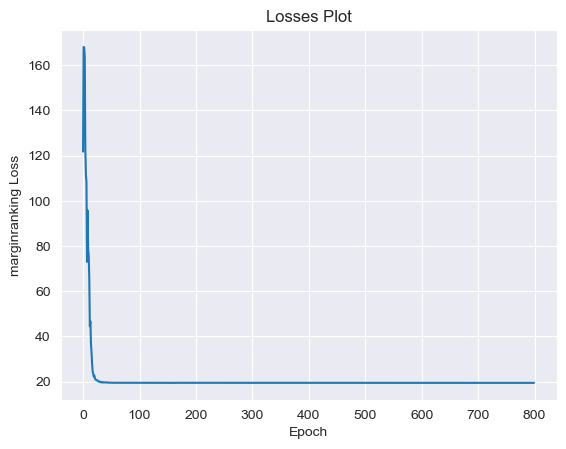

In [65]:
final_model_RESCAL.plot_losses()

In [24]:
# directory to save the final model 
final_model_directory = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_RESCAL/final_multiple_RESCAL"

# saing the final model 
final_model_RESCAL.save_to_directory(final_model_directory)

NameError: name 'final_model_RESCAL' is not defined

In [96]:
#source code: https://towardsdatascience.com/how-to-generate-and-evaluate-the-performance-of-knowledge-graph-embeddings-95789abcb0c1

# get entity labels from training set
entity_labels = training_factory.entity_labeling.all_labels()

# convert entities to ids
entity_ids = torch.as_tensor(training_factory.entities_to_ids(entity_labels))

# retrieve the embeddings using entity ids
entity_embeddings = final_model_RESCAL.model.entity_representations[0](indices=entity_ids)

# create a dictionary of entity labels and embeddings
entity_embeddings_dict = dict(zip(entity_labels, entity_embeddings.detach().numpy()))

In [97]:
# indicateing the embeddings
embeddings = list(entity_embeddings_dict.values())

# Apply PCA
pca = PCA(n_components=2) 

# creating reduced-dimensional embeddings 
reduced_embeddings = pca.fit_transform(embeddings)

---

## 3. ConvE model

This section consists of an example of the basic ConvE model, the hyperparameter tuning for it and later the evaluation with the example of prediction.

### 3.1 ConvE model - simple example 

We will start with the basic model example once more to see how the model behaves with data. The parameters that I will be tuning are the same as for the RESCAL model. 

*The code is the same as for RESCAL but adjusted to the ConvE*


NoTrainingBatchError: Did not have a single training batch! This typically happens if the batch_size is set larger than the number of training instances, and drop_last is set to True. The latter happens by default, if the model uses batch norm layers. You can try to fix this problem, by explicitly setting drop_last=False. If you are using the pipeline, you find the parameter in the training_kwargs. Further information can be found at https://github.com/pykeen/pykeen/issues/828 .

because of this error I needed to set the batch_size to something smaller than 75, as that is the size of the trianing set

In [9]:
# generating the first model 
model_multiple_conve_simple = pipeline(
    training=training_factory,
    training_kwargs= dict(
        drop_last =True, 
        batch_size = 75),
    testing=testing_factory,
    validation = validation_factory, 
    model= "ConvE",
    training_loop = "slcwa",
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,    
    ),
    random_seed=42)

INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1 (100.00%) batches).


Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/12.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds


In [12]:
# setting directory to save the model and all its parameters 
dir_model_multiple_conve = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_CONVE"


In [14]:
# saving the model_multiple_basic
model_multiple_conve_simple.save_to_directory(dir_model_multiple_conve)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=132, num_relations=20, create_inverse_triples=False, num_triples=100) to file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_CONVE/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_CONVE


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

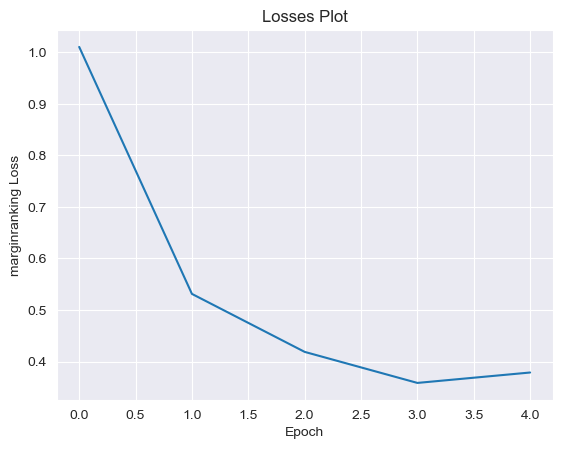

In [10]:
model_multiple_conve_simple.plot_losses()

### 3.2 ConvE model - hyperparameter tuning

In this section, I tune the ConvE model's hyperparameters. Some of the intervals for which the parameters are tuned were taken from the Pykeen website and adjusted to the size of the data set, and the `hpo_pipeline()` automatically tunes for them in some cases. Then I take the best parameters produced and apply them to the standard pipeline. 


In [30]:
hpo_pipeline_result_conve = hpo_pipeline(
    n_trials=30,
    training=training_factory,
     training_kwargs= dict(
        drop_last =True),
    testing=testing_factory,
    validation = validation_factory, 
    model= "ConvE",
    lr_scheduler='ExponentialLR',
    lr_scheduler_kwargs_ranges=dict(
        gamma=dict(type=float, low=0.8, high=1.0),
    ),
    training_loop = "slcwa",
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,    
    )    
)

[I 2023-06-21 20:11:02,396] A new study created in memory with name: no-name-1ea0c592-e092-4f92-8c82-41cf23ae6bd1
INFO:pykeen.hpo.hpo:Using model: <class 'pykeen.models.unimodal.conv_e.ConvE'>
INFO:pykeen.hpo.hpo:Using loss: <class 'pykeen.losses.BCEAfterSigmoidLoss'>
INFO:pykeen.hpo.hpo:Using optimizer: <class 'torch.optim.adam.Adam'>
INFO:pykeen.hpo.hpo:Using lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
INFO:pykeen.hpo.hpo:Using training loop: <class 'pykeen.training.slcwa.SLCWATrainingLoop'>
INFO:pykeen.hpo.hpo:Using negative sampler: <class 'pykeen.sampling.basic_negative_sampler.BasicNegativeSampler'>
INFO:pykeen.hpo.hpo:Using evaluator: <class 'pykeen.evaluation.rank_based_evaluator.RankBasedEvaluator'>
INFO:pykeen.hpo.hpo:Attempting to maximize both.realistic.inverse_harmonic_mean_rank
INFO:pykeen.hpo.hpo:Filter validation triples when testing: True
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be d

Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/6 (16.67%) batches).


Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

c:\Users\wlibe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
[I 2023-06-21 20:25:08,251] Trial 1 finished with value: 0.1934458613395691 and parameters: {'model.output_channels': 32, 'model.input_dropout': 0.5, 'model.output_dropout': 0.5, 'model.feature_map_dropout': 0.0, 'optimizer.lr': 0.07311107363301621, 'lr_scheduler.gamma': 0.8837848982298409, 'negative_sampler.num_negs_per_pos': 48, 'training.num_epochs': 1000, 'training.batch_size': 16}. Best is trial 1 with value: 0.1934458613395691.
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.
[W 2023-06-21 20:25:08,287] Trial 2 failed with parameters: {'model.output_channels': 16, 'model.input_dropout': 0.1, 'model.output_dropout': 0.1, 'model.feature_map_dropout':

Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1 (100.00%) batches).


Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
[I 2023-06-21 20:26:35,979] Trial 4 finished with value: 0.04981771856546402 and parameters: {'model.output_channels': 32, 'model.input_dropout': 0.4, 'model.output_dropout': 0.0, 'model.feature_map_dropout': 0.1, 'optimizer.lr': 0.036125610257893806, 'lr_scheduler.gamma': 0.8613016313913479, 'negative_sampler.num_negs_per_pos': 31, 'training.num_epochs': 200, 'training.batch_size': 64}. Best is trial 1 with value: 0.1934458613395691.
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.
[W 2023-06-21 20:26:36,021] Trial 5 failed with parameters: {'model.output_channels': 16, 'model.input_dropout': 0.4, 'model.output_dropout': 0.30000000000000004, 'model.feat

Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/3 (33.33%) batches).


Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
[I 2023-06-21 20:33:15,964] Trial 11 finished with value: 0.26319512724876404 and parameters: {'model.output_channels': 32, 'model.input_dropout': 0.4, 'model.output_dropout': 0.4, 'model.feature_map_dropout': 0.30000000000000004, 'optimizer.lr': 0.040051093486250015, 'lr_scheduler.gamma': 0.8514039201039556, 'negative_sampler.num_negs_per_pos': 21, 'training.num_epochs': 800, 'training.batch_size': 32}. Best is trial 11 with value: 0.26319512724876404.
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.
[W 2023-06-21 20:33:16,006] Trial 12 failed with parameters: {'model.output_channels': 32, 'model.input_dropout': 0.5, 'model.output_dropout': 0.3000000000

Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/3 (33.33%) batches).


Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
[I 2023-06-21 20:34:35,115] Trial 13 finished with value: 0.06035229936242104 and parameters: {'model.output_channels': 16, 'model.input_dropout': 0.2, 'model.output_dropout': 0.30000000000000004, 'model.feature_map_dropout': 0.5, 'optimizer.lr': 0.0087602148133765, 'lr_scheduler.gamma': 0.8407163892869609, 'negative_sampler.num_negs_per_pos': 83, 'training.num_epochs': 100, 'training.batch_size': 32}. Best is trial 11 with value: 0.26319512724876404.
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.
[W 2023-06-21 20:34:35,145] Trial 14 failed with parameters: {'model.output_channels': 16, 'model.input_dropout': 0.1, 'model.output_dropout': 0.300000000000

Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1 (100.00%) batches).


Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
[I 2023-06-21 20:35:14,395] Trial 16 finished with value: 0.04840282350778579 and parameters: {'model.output_channels': 32, 'model.input_dropout': 0.2, 'model.output_dropout': 0.0, 'model.feature_map_dropout': 0.0, 'optimizer.lr': 0.07597192309962687, 'lr_scheduler.gamma': 0.9590105532673123, 'negative_sampler.num_negs_per_pos': 1, 'training.num_epochs': 200, 'training.batch_size': 64}. Best is trial 11 with value: 0.26319512724876404.
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.
[W 2023-06-21 20:35:14,465] Trial 17 failed with parameters: {'model.output_channels': 64, 'model.input_dropout': 0.1, 'model.output_dropout': 0.1, 'model.feature_map_dropou

Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1 (100.00%) batches).


Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/13.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
[I 2023-06-21 20:42:31,990] Trial 27 finished with value: 0.033957816660404205 and parameters: {'model.output_channels': 64, 'model.input_dropout': 0.5, 'model.output_dropout': 0.1, 'model.feature_map_dropout': 0.4, 'optimizer.lr': 0.03212752304586816, 'lr_scheduler.gamma': 0.8420025648986633, 'negative_sampler.num_negs_per_pos': 28, 'training.num_epochs': 700, 'training.batch_size': 64}. Best is trial 11 with value: 0.26319512724876404.
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.
[W 2023-06-21 20:42:32,051] Trial 28 failed with parameters: {'model.output_channels': 32, 'model.input_dropout': 0.5, 'model.output_dropout': 0.1, 'model.feature_map_drop

In [31]:
# setting directory to save the model and all its parameters 
dir_model_multiple_CONVE = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_CONVE"

# saving the model_multiple_basic
hpo_pipeline_result_conve.save_to_directory(dir_model_multiple_CONVE)

Now knowing the best parameters from tuning, we can put them into a `pipeline()` to create the final model 

In [35]:
final_model_multiple_conve = pipeline(
    evaluator = "rankbased",
    filter_validation_when_testing= True,
    loss= "bceaftersigmoid",
    lr_scheduler= "exponential",
    lr_scheduler_kwargs= dict( 
      gamma = 0.8514039201039556
    ),
    model = "conve",
    model_kwargs= dict(
      feature_map_dropout = 0.30000000000000004,
      input_dropout = 0.4,
      output_channels = 32,
      output_dropout = 0.4
    ),
    negative_sampler = "basic",
    negative_sampler_kwargs= dict(
      filtered =  True,
      num_negs_per_pos = 21
    ),
    optimizer = "adam",
    optimizer_kwargs = dict(
      lr = 0.040051093486250015
    ),
    testing=  testing_factory,
    training = training_factory,
    training_kwargs= dict( 
      batch_size = 32,
      drop_last = True,
      num_epochs= 800
    ),
    training_loop= "slcwa",
    validation=  validation_factory,
    use_testing_data = True, 
    random_seed=42
)

INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/3 (33.33%) batches).


Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/12.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


In [45]:
# setting directory to save the model and all its parameters 
dir_model_multiple_CONVE_final = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_CONVE/final_multiple_CONVE"


# saving the model_multiple_basic
final_model_multiple_conve.save_to_directory(dir_model_multiple_CONVE_final)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=132, num_relations=20, create_inverse_triples=False, num_triples=100) to file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_CONVE/final_multiple_CONVE/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_CONVE/final_multiple_CONVE


### 3.3 ConvE model - evaluation and prediction

This section is dedicated to reading the evaluation of the model as well as predicting some of the examples to see how the model did.

<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='bceaftersigmoid Loss'>

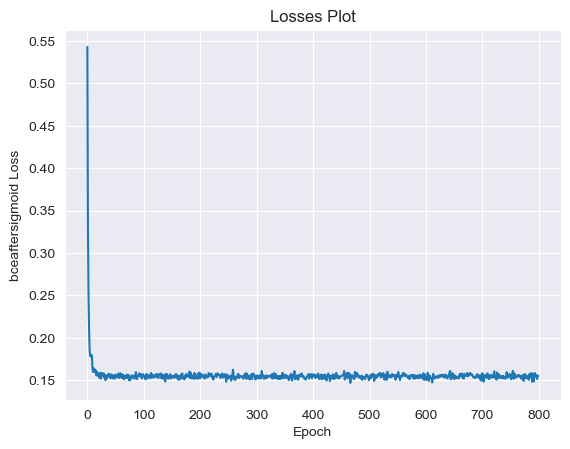

In [36]:
final_model_multiple_conve.plot_losses()

In [101]:
#source code: https://towardsdatascience.com/how-to-generate-and-evaluate-the-performance-of-knowledge-graph-embeddings-95789abcb0c1

# get entity labels from training set
entity_labels_C = training_factory.entity_labeling.all_labels()

# convert entities to ids
entity_ids_C = torch.as_tensor(training_factory.entities_to_ids(entity_labels_C))

# retrieve the embeddings using entity ids
entity_embeddings_C = final_model_multiple_conve.model.entity_representations[0](indices=entity_ids_C)

# create a dictionary of entity labels and embeddings
entity_embeddings_dict_C = dict(zip(entity_labels_C, entity_embeddings_C.detach().numpy()))

--- 

## 4. Making the predcition of tail using the test set. 

To compare the models and how they perform in terms of tail prediction, both are applied to the test set triples to see if they predict the correct tail. 

To accomplish this, I first printed all of the triples in the data set, found their labels, and used the function `predict_target()`, where we specify the head and tail entities. The data frame is then sorted so that the best score appears first in the table. 


In [47]:
import torch

#to load the model from the file
final_model_RESCAL_multiple = torch.load("C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_multiple_RESCAL/final_multiple_RESCAL/trained_model.pkl")

In [179]:
test_triples


tensor([[ 82,  10,  69],
        [ 59,  15,  69],
        [ 52,   5,  37],
        [107,  10,  69],
        [ 83,  14,  91],
        [ 12,   6,  37],
        [ 34,  19,  22],
        [130,   4,  69],
        [ 30,  19,  22],
        [ 20,  13,  69],
        [119,  14,  91],
        [ 62,  15,  69]])

In [180]:
entity_to_id 

{'FieldQRasterAPlainRatioAObjectQPlainVectorRegionACountA': 0,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionACyclicA': 1,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionAERA': 2,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionAIRA': 3,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionANominalA': 4,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionAPlainIntervalA': 5,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionAPlainNominalA': 6,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionAPlainOrdinalA': 7,
 'FieldQRasterAPlainRatioAObjectQPlainVectorRegionAPlainRatioA': 8,
 'ObjectQPlainVectorRegionACountA': 9,
 'ObjectQPlainVectorRegionACountAFieldQPlainVectorRegionAPlainNominalA': 10,
 'ObjectQPlainVectorRegionACountAFieldQRasterAPlainRatioA': 11,
 'ObjectQPlainVectorRegionACountAFieldQVectorTessellationAPlainNominalA': 12,
 'ObjectQPlainVectorRegionACountAFieldQVectorTessellationAPlainOrdinalA': 13,
 'ObjectQPlainVectorRegionACountAObjectQPlainVectorRegionABooleanA': 14,


In [182]:
relation_to_id

{'ClipObject2Object': 0,
 'IntersectDissolveField2Object': 1,
 'JoinCountAttribute': 2,
 'JoinObjectRatios': 3,
 'LoadCountAmounts': 4,
 'SelectLayerByLocationPlainRegionObjects': 5,
 'SelectLayerByLocationPlainRegionObjectsFieldDist': 6,
 'SelectLayerByLocationTessObject': 7,
 'SelectLayerByLocationTessObjects': 8,
 'SelectNeighborhoodsByLocationDistPointObject': 9,
 'SpatialJoinCountTess': 10,
 'SpatialJoinMeanTessCount': 11,
 'SpatialJoinMeanTessRatio': 12,
 'SpatialJoinSumTessCount': 13,
 'SpatialJoinSumTessRatio': 14,
 'SummarizeWithin': 15,
 'ZonalStatisticsMeanInterval': 16,
 'ZonalStatisticsMeanRatio': 17,
 'ZonalStatisticsSize': 18,
 'ZonalStatisticsSumField': 19}

The first example: 

triple:  (52, 5, 37)

52 = 'ObjectQPointAPlainNominalAObjectQPlainVectorRegionACountA'  
5 = 'SelectLayerByLocationPlainRegionObjects'  
37 = 'ObjectQPlainVectorRegionAPlainNominalA'  

In [216]:
#first predition for rescal 
pred_example_R_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head="ObjectQPointAPlainNominalAObjectQPlainVectorRegionACountA",
    relation="SelectLayerByLocationPlainRegionObjects",
    triples_factory= final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_test_df = pred_example_R_test.sort_values(by='score', ascending=False)
pred_example_R_test_df = pred_example_R_test_df.head(10)
pred_example_R_test_df 

tail_id       score                                         tail_label
37        37  612.110840             ObjectQPlainVectorRegionAPlainNominalA
111      111  583.484741  ObjectQVectorTessellationANominalAObjectQVecto...
84        84  578.152893  ObjectQVectorTessellationACyclicAObjectQPointAIRA
126      126  577.128296  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
87        87  576.068481  ObjectQVectorTessellationACyclicAObjectQPointA...
48        48  572.972107  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
115      115  570.994751  ObjectQVectorTessellationAPlainIntervalAFieldQ...
128      128  570.117615  ObjectQVectorTessellationAPlainRatioAObjectQPo...
13        13  567.711304  ObjectQPlainVectorRegionACountAFieldQVectorTes...
17        17  566.407288  ObjectQPlainVectorRegionACountAObjectQPlainVec...

In [194]:
pred_example_R_test_df .to_excel('example_1_RESCAL_test_triple.xlsx')

In [218]:
#first predition for conve 
pred_example_C_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head="ObjectQPointAPlainNominalAObjectQPlainVectorRegionACountA",
    relation="SelectLayerByLocationPlainRegionObjects",
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_test_df = pred_example_C_test.sort_values(by='score', ascending=False)
pred_example_C_test_df = pred_example_C_test_df.head(10)
pred_example_C_test_df

tail_id     score                                         tail_label
127      127 -0.059070              ObjectQVectorTessellationAPlainRatioA
120      120 -0.616082            ObjectQVectorTessellationAPlainNominalA
58        58 -0.726624                            ObjectQVectorRegionAERA
22        22 -0.730800                       ObjectQPlainVectorRegionAERA
37        37 -0.749760             ObjectQPlainVectorRegionAPlainNominalA
45        45 -0.753016               ObjectQPlainVectorRegionAPlainRatioA
9          9 -0.829094                    ObjectQPlainVectorRegionACountA
91        91 -0.925165                      ObjectQVectorTessellationAERA
114      114 -1.003614           ObjectQVectorTessellationAPlainIntervalA
92        92 -1.044734  ObjectQVectorTessellationAERAFieldQRasterAPlai...

In [196]:
pred_example_C_test_df.to_excel('example_1_CONVE_test_triple.xlsx')

That would be the second example

triple: (119,14,91)

119 = 'ObjectQVectorTessellationAPlainIntervalAObjectQVectorTessellationAERA'  
14 = 'SelectLayerByLocationPlainRegionObjects'  
91 = ' 'ObjectQVectorTessellationAERA'  

In [246]:
#first predition for rescal 
pred_example_R_multiple_2_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQVectorTessellationAPlainIntervalAObjectQVectorTessellationAERA',
    relation="SelectLayerByLocationPlainRegionObjects",
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_2_test  = pred_example_R_multiple_2_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_2_test = pred_example_R_multiple_df_2_test.head(30)

In [247]:
pred_example_R_multiple_df_2_test

tail_id        score                                         tail_label
37        37  3977.418945             ObjectQPlainVectorRegionAPlainNominalA
111      111  3769.173340  ObjectQVectorTessellationANominalAObjectQVecto...
84        84  3737.033447  ObjectQVectorTessellationACyclicAObjectQPointAIRA
126      126  3725.948730  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
87        87  3719.825684  ObjectQVectorTessellationACyclicAObjectQPointA...
115      115  3715.546631  ObjectQVectorTessellationAPlainIntervalAFieldQ...
48        48  3705.954102  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
128      128  3687.279785  ObjectQVectorTessellationAPlainRatioAObjectQPo...
75        75  3667.486572  ObjectQVectorTessellationACyclicAObjectQPlainV...
113      113  3660.246582  ObjectQVectorTessellationAOrdinalAObjectQVecto...
13        13  3658.222168  ObjectQPlainVectorRegionACountAFieldQVectorTes...
56        56  3656.296387  ObjectQPointAPlainRatioAObjectQPlainVectorRegi...
93        93  3651.288330   ObjectQVectorTessellationAERAObjectQPointACountA
17        17  3639.881592  ObjectQPlainVectorRegionACountAObjectQPlainVec...
67        67  3630.612305  ObjectQVectorTessellationABooleanAObjectQVecto...
85        85  3630.220703  ObjectQVectorTessellationACyclicAObjectQPointA...
36        36  3629.238281  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
69        69  3627.233398                   ObjectQVectorTessellationACountA
96        96  3623.885254  ObjectQVectorTessellationAIRAObjectQVectorTess...
124      124  3620.574707  ObjectQVectorTessellationAPlainNominalAObjectQ...
123      123  3617.060547  ObjectQVectorTessellationAPlainNominalAObjectQ...
77        77  3616.659668  ObjectQVectorTessellationACyclicAObjectQPlainV...
44        44  3615.624512  ObjectQPlainVectorRegionAPlainOrdinalAObjectQV...
98        98  3606.844238  ObjectQVectorTessellationAIRAObjectQVectorTess...
86        86  3604.455322  ObjectQVectorTessellationACyclicAObjectQPointA...
53        53  3581.435547  ObjectQPointAPlainNominalAObjectQVectorTessell...
73        73  3579.885498  ObjectQVectorTessellationACountAObjectQVectorT...
110      110  3576.358643  ObjectQVectorTessellationANominalAObjectQVecto...
74        74  3574.454346  ObjectQVectorTessellationACountAObjectQVectorT...
42        42  3566.557861  ObjectQPlainVectorRegionAPlainOrdinalAFieldQRa...

In [209]:
pred_example_R_multiple_df_2_test.to_excel('example_2_RESCAL_test_triple.xlsx')

In [219]:
#first predition for Conve 
pred_example_C_multiple_2_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQVectorTessellationAPlainIntervalAObjectQVectorTessellationAERA' ,
    relation="SelectLayerByLocationPlainRegionObjects",
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_2_test  = pred_example_C_multiple_2_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_2_test = pred_example_C_multiple_df_2_test.head(10)
pred_example_C_multiple_df_2_test

tail_id     score                                         tail_label
127      127 -0.099400              ObjectQVectorTessellationAPlainRatioA
58        58 -0.756368                            ObjectQVectorRegionAERA
37        37 -0.778548             ObjectQPlainVectorRegionAPlainNominalA
45        45 -0.824597               ObjectQPlainVectorRegionAPlainRatioA
22        22 -0.826998                       ObjectQPlainVectorRegionAERA
120      120 -0.852820            ObjectQVectorTessellationAPlainNominalA
9          9 -1.017316                    ObjectQPlainVectorRegionACountA
91        91 -1.135849                      ObjectQVectorTessellationAERA
114      114 -1.174197           ObjectQVectorTessellationAPlainIntervalA
48        48 -1.177092  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...

In [211]:
pred_example_C_multiple_df_2_test.to_excel('example_2_CONVE_test_triple.xlsx')

Now the third example

triple: (130, 4, 69)

130 = 'ObjectQVectorTessellationAPlainRatioAObjectQVectorTessellationACountA  
4 = 'LoadCountAmounts'  
69 =  'ObjectQVectorTessellationACountA'   

In [212]:
#first predition for rescal 
pred_example_R_multiple_3_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQVectorTessellationAPlainRatioAObjectQVectorTessellationACountA',
    relation='LoadCountAmounts',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_3_test  = pred_example_R_multiple_3_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_3_test = pred_example_R_multiple_df_3_test.head(10)

In [213]:
pred_example_R_multiple_df_3_test 

tail_id        score                                         tail_label
69        69  3888.658691                   ObjectQVectorTessellationACountA
126      126  3598.873047  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
111      111  3559.334961  ObjectQVectorTessellationANominalAObjectQVecto...
87        87  3557.712891  ObjectQVectorTessellationACyclicAObjectQPointA...
48        48  3538.357178  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
84        84  3531.245605  ObjectQVectorTessellationACyclicAObjectQPointAIRA
36        36  3519.134033  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
56        56  3518.723633  ObjectQPointAPlainRatioAObjectQPlainVectorRegi...
113      113  3507.201172  ObjectQVectorTessellationAOrdinalAObjectQVecto...
13        13  3500.032715  ObjectQPlainVectorRegionACountAFieldQVectorTes...

In [214]:
pred_example_R_multiple_df_3_test.to_excel('example_3_RESCAL_test_triple.xlsx')

In [215]:
#first predition for Conve 
pred_example_C_multiple_3_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQVectorTessellationAPlainRatioAObjectQVectorTessellationACountA',
    relation='LoadCountAmounts',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_3_test  = pred_example_C_multiple_3_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_3_test = pred_example_C_multiple_df_3_test.head(10)
pred_example_C_multiple_df_3_test

tail_id     score                                         tail_label
69        69 -0.433378                   ObjectQVectorTessellationACountA
120      120 -0.437468            ObjectQVectorTessellationAPlainNominalA
25        25 -1.014759                       ObjectQPlainVectorRegionAIRA
123      123 -1.188339  ObjectQVectorTessellationAPlainNominalAObjectQ...
85        85 -1.188353  ObjectQVectorTessellationACyclicAObjectQPointA...
9          9 -1.257892                    ObjectQPlainVectorRegionACountA
37        37 -1.302388             ObjectQPlainVectorRegionAPlainNominalA
22        22 -1.447348                       ObjectQPlainVectorRegionAERA
91        91 -1.503693                      ObjectQVectorTessellationAERA
113      113 -1.524379  ObjectQVectorTessellationAOrdinalAObjectQVecto...

In [248]:
pred_example_C_multiple_df_3_test.to_excel('example_3_CONVE_test_triple.xlsx')

---
82 = 'ObjectQVectorTessellationACyclicAObjectQPointACountA'  
10 ='SpatialJoinCountTess'  
69 = 'ObjectQVectorTessellationACountA'  

In [221]:
#first predition for rescal 
pred_example_R_multiple_4_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQVectorTessellationACyclicAObjectQPointACountA',
    relation='SpatialJoinCountTess',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_4_test  = pred_example_R_multiple_4_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_4_test = pred_example_R_multiple_df_4_test.head(10)
pred_example_R_multiple_df_4_test

tail_id        score                                         tail_label
69        69  2801.349854                   ObjectQVectorTessellationACountA
126      126  2491.655273  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
87        87  2489.305420  ObjectQVectorTessellationACyclicAObjectQPointA...
111      111  2472.310547  ObjectQVectorTessellationANominalAObjectQVecto...
48        48  2469.615723  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
84        84  2447.696289  ObjectQVectorTessellationACyclicAObjectQPointAIRA
36        36  2438.571289  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
113      113  2432.261719  ObjectQVectorTessellationAOrdinalAObjectQVecto...
56        56  2422.273926  ObjectQPointAPlainRatioAObjectQPlainVectorRegi...
13        13  2418.688721  ObjectQPlainVectorRegionACountAFieldQVectorTes...

In [223]:
#first predition for Conve 
pred_example_C_multiple_4_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQVectorTessellationACyclicAObjectQPointACountA',
    relation='SpatialJoinCountTess',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_4_test  = pred_example_C_multiple_4_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_4_test = pred_example_C_multiple_df_4_test.head(10)
pred_example_C_multiple_df_4_test

tail_id     score                                         tail_label
127      127 -0.051926              ObjectQVectorTessellationAPlainRatioA
58        58 -0.353865                            ObjectQVectorRegionAERA
9          9 -0.359744                    ObjectQPlainVectorRegionACountA
45        45 -0.360020               ObjectQPlainVectorRegionAPlainRatioA
120      120 -0.433279            ObjectQVectorTessellationAPlainNominalA
37        37 -0.481958             ObjectQPlainVectorRegionAPlainNominalA
48        48 -0.502062  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
91        91 -0.503913                      ObjectQVectorTessellationAERA
22        22 -0.506078                       ObjectQPlainVectorRegionAERA
114      114 -0.516678           ObjectQVectorTessellationAPlainIntervalA

59 = 'ObjectQVectorTessellationABooleanAObjectQPointACountA'  
15 = 'SummarizeWithin'  
69 = 'ObjectQVectorTessellationACountA'  

In [224]:
#first predition for rescal 
pred_example_R_multiple_5_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQVectorTessellationABooleanAObjectQPointACountA',
    relation='SummarizeWithin',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_5_test  = pred_example_R_multiple_5_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_5_test = pred_example_R_multiple_df_5_test.head(10)
pred_example_R_multiple_df_5_test

tail_id       score                                         tail_label
69        69  628.358643                   ObjectQVectorTessellationACountA
126      126  576.550537  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
111      111  568.007141  ObjectQVectorTessellationANominalAObjectQVecto...
87        87  566.907776  ObjectQVectorTessellationACyclicAObjectQPointA...
48        48  564.442688  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
36        36  561.656860  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
84        84  560.894653  ObjectQVectorTessellationACyclicAObjectQPointAIRA
56        56  558.074097  ObjectQPointAPlainRatioAObjectQPlainVectorRegi...
67        67  557.006897  ObjectQVectorTessellationABooleanAObjectQVecto...
128      128  556.201660  ObjectQVectorTessellationAPlainRatioAObjectQPo...

In [227]:
#first predition for Conve 
pred_example_C_multiple_5_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQVectorTessellationABooleanAObjectQPointACountA',
    relation='SummarizeWithin',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_5_test  = pred_example_C_multiple_5_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_5_test = pred_example_C_multiple_df_5_test.head(10)
pred_example_C_multiple_df_5_test

tail_id     score                                         tail_label
127      127 -0.117450              ObjectQVectorTessellationAPlainRatioA
120      120 -0.145155            ObjectQVectorTessellationAPlainNominalA
58        58 -0.494616                            ObjectQVectorRegionAERA
9          9 -0.512940                    ObjectQPlainVectorRegionACountA
123      123 -0.560696  ObjectQVectorTessellationAPlainNominalAObjectQ...
69        69 -0.565304                   ObjectQVectorTessellationACountA
91        91 -0.578456                      ObjectQVectorTessellationAERA
22        22 -0.633257                       ObjectQPlainVectorRegionAERA
42        42 -0.641526  ObjectQPlainVectorRegionAPlainOrdinalAFieldQRa...
37        37 -0.653343             ObjectQPlainVectorRegionAPlainNominalA

107 = 'ObjectQVectorTessellationANominalAObjectQPlainVectorRegionAPlainNominalA
10 = 'SpatialJoinCountTess'
69 = 'ObjectQVectorTessellationACountA'


In [226]:
#first predition for rescal 
pred_example_R_multiple_6_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQVectorTessellationANominalAObjectQPlainVectorRegionAPlainNominalA',
    relation='SpatialJoinCountTess',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_6_test  = pred_example_R_multiple_6_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_6_test = pred_example_R_multiple_df_6_test.head(10)
pred_example_R_multiple_df_6_test

tail_id        score                                         tail_label
69        69  3292.999512                   ObjectQVectorTessellationACountA
126      126  2950.798828  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
87        87  2936.865723  ObjectQVectorTessellationACyclicAObjectQPointA...
111      111  2924.111328  ObjectQVectorTessellationANominalAObjectQVecto...
48        48  2910.705078  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
84        84  2892.484375  ObjectQVectorTessellationACyclicAObjectQPointAIRA
113      113  2883.640137  ObjectQVectorTessellationAOrdinalAObjectQVecto...
36        36  2875.598145  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
67        67  2872.580078  ObjectQVectorTessellationABooleanAObjectQVecto...
13        13  2863.128906  ObjectQPlainVectorRegionACountAFieldQVectorTes...

In [228]:
#first predition for Conve 
pred_example_C_multiple_6_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQVectorTessellationANominalAObjectQPlainVectorRegionAPlainNominalA',
    relation='SpatialJoinCountTess',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_6_test  = pred_example_C_multiple_6_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_6_test = pred_example_C_multiple_df_6_test.head(10)
pred_example_C_multiple_df_6_test

tail_id     score                                tail_label
127      127 -0.021878     ObjectQVectorTessellationAPlainRatioA
22        22 -0.222886              ObjectQPlainVectorRegionAERA
58        58 -0.261685                   ObjectQVectorRegionAERA
37        37 -0.281874    ObjectQPlainVectorRegionAPlainNominalA
91        91 -0.311175             ObjectQVectorTessellationAERA
69        69 -0.322880          ObjectQVectorTessellationACountA
114      114 -0.331729  ObjectQVectorTessellationAPlainIntervalA
45        45 -0.332586      ObjectQPlainVectorRegionAPlainRatioA
9          9 -0.336191           ObjectQPlainVectorRegionACountA
120      120 -0.340011   ObjectQVectorTessellationAPlainNominalA

83 =  'ObjectQVectorTessellationACyclicAObjectQPointAERA'
14 =  'SpatialJoinSumTessRatio'
91 =  'ObjectQVectorTessellationAERA'


In [229]:
#first predition for rescal 
pred_example_R_multiple_7_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQVectorTessellationACyclicAObjectQPointAERA',
    relation='SpatialJoinSumTessRatio',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_7_test  = pred_example_R_multiple_7_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_7_test = pred_example_R_multiple_df_7_test.head(10)
pred_example_R_multiple_df_7_test

tail_id        score                                         tail_label
91        91  3025.247559                      ObjectQVectorTessellationAERA
69        69  2941.276855                   ObjectQVectorTessellationACountA
48        48  2938.592285  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
128      128  2932.507812  ObjectQVectorTessellationAPlainRatioAObjectQPo...
126      126  2929.427734  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
124      124  2911.644531  ObjectQVectorTessellationAPlainNominalAObjectQ...
111      111  2908.700195  ObjectQVectorTessellationANominalAObjectQVecto...
87        87  2908.420410  ObjectQVectorTessellationACyclicAObjectQPointA...
44        44  2898.786133  ObjectQPlainVectorRegionAPlainOrdinalAObjectQV...
56        56  2895.841797  ObjectQPointAPlainRatioAObjectQPlainVectorRegi...

In [231]:
#first predition for Conve 
pred_example_C_multiple_7_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQVectorTessellationACyclicAObjectQPointAERA',
    relation='SpatialJoinSumTessRatio',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_7_test  = pred_example_C_multiple_7_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_7_test = pred_example_C_multiple_df_7_test.head(10)
pred_example_C_multiple_df_7_test

tail_id     score                                tail_label
127      127 -0.062147     ObjectQVectorTessellationAPlainRatioA
120      120 -0.442681   ObjectQVectorTessellationAPlainNominalA
91        91 -0.485946             ObjectQVectorTessellationAERA
9          9 -0.508201           ObjectQPlainVectorRegionACountA
58        58 -0.533864                   ObjectQVectorRegionAERA
45        45 -0.539779      ObjectQPlainVectorRegionAPlainRatioA
37        37 -0.589204    ObjectQPlainVectorRegionAPlainNominalA
22        22 -0.612134              ObjectQPlainVectorRegionAERA
69        69 -0.653474          ObjectQVectorTessellationACountA
114      114 -0.702494  ObjectQVectorTessellationAPlainIntervalA

12 = 'ObjectQPlainVectorRegionACountAFieldQVectorTessellationAPlainNominalA'
6 =  'SelectLayerByLocationPlainRegionObjectsFieldDist'
37 = 'ObjectQPlainVectorRegionAPlainNominalA'


In [232]:
#first predition for rescal 
pred_example_R_multiple_8_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQPlainVectorRegionACountAFieldQVectorTessellationAPlainNominalA',
    relation='SelectLayerByLocationPlainRegionObjectsFieldDist',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_8_test  = pred_example_R_multiple_8_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_8_test = pred_example_R_multiple_df_8_test.head(10)
pred_example_R_multiple_df_8_test

tail_id        score                                         tail_label
37        37  3571.730225             ObjectQPlainVectorRegionAPlainNominalA
111      111  3383.412354  ObjectQVectorTessellationANominalAObjectQVecto...
84        84  3338.443115  ObjectQVectorTessellationACyclicAObjectQPointAIRA
87        87  3331.983887  ObjectQVectorTessellationACyclicAObjectQPointA...
126      126  3331.470459  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
115      115  3313.863037  ObjectQVectorTessellationAPlainIntervalAFieldQ...
128      128  3309.839111  ObjectQVectorTessellationAPlainRatioAObjectQPo...
48        48  3304.871582  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
93        93  3274.281250   ObjectQVectorTessellationAERAObjectQPointACountA
75        75  3271.156494  ObjectQVectorTessellationACyclicAObjectQPlainV...

In [233]:
#first predition for Conve 
pred_example_C_multiple_8_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQPlainVectorRegionACountAFieldQVectorTessellationAPlainNominalA',
    relation='SelectLayerByLocationPlainRegionObjectsFieldDist',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_8_test  = pred_example_C_multiple_8_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_8_test = pred_example_C_multiple_df_8_test.head(10)
pred_example_C_multiple_df_8_test

tail_id     score                                         tail_label
58        58 -0.136612                            ObjectQVectorRegionAERA
37        37 -0.354154             ObjectQPlainVectorRegionAPlainNominalA
127      127 -0.492343              ObjectQVectorTessellationAPlainRatioA
120      120 -0.931763            ObjectQVectorTessellationAPlainNominalA
91        91 -0.944252                      ObjectQVectorTessellationAERA
9          9 -1.059402                    ObjectQPlainVectorRegionACountA
22        22 -1.063698                       ObjectQPlainVectorRegionAERA
114      114 -1.066098           ObjectQVectorTessellationAPlainIntervalA
69        69 -1.124362                   ObjectQVectorTessellationACountA
20        20 -1.182242  ObjectQPlainVectorRegionACountAObjectQVectorTe...

34 = 'ObjectQPlainVectorRegionAPlainIntervalAFieldQRasterAPlainRatioA'
19 = 'ZonalStatisticsSumField'
22 =  'ObjectQPlainVectorRegionAERA'

In [234]:
#first predition for rescal 
pred_example_R_multiple_9_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQPlainVectorRegionAPlainIntervalAFieldQRasterAPlainRatioA',
    relation='ZonalStatisticsSumField',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_9_test  = pred_example_R_multiple_9_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_9_test = pred_example_R_multiple_df_9_test.head(10)
pred_example_R_multiple_df_9_test

tail_id       score                                         tail_label
126      126  519.386841  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
22        22  513.123169                       ObjectQPlainVectorRegionAERA
115      115  510.374146  ObjectQVectorTessellationAPlainIntervalAFieldQ...
36        36  507.551331  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
84        84  507.401184  ObjectQVectorTessellationACyclicAObjectQPointAIRA
111      111  505.852722  ObjectQVectorTessellationANominalAObjectQVecto...
75        75  503.564606  ObjectQVectorTessellationACyclicAObjectQPlainV...
48        48  503.183838  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
113      113  501.780212  ObjectQVectorTessellationAOrdinalAObjectQVecto...
44        44  501.411865  ObjectQPlainVectorRegionAPlainOrdinalAObjectQV...

In [235]:
#first predition for Conve 
pred_example_C_multiple_9_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQPlainVectorRegionAPlainIntervalAFieldQRasterAPlainRatioA',
    relation='ZonalStatisticsSumField',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_9_test  = pred_example_C_multiple_9_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_9_test = pred_example_C_multiple_df_9_test.head(10)
pred_example_C_multiple_df_9_test

tail_id     score                                tail_label
127      127  0.012387     ObjectQVectorTessellationAPlainRatioA
22        22 -0.352964              ObjectQPlainVectorRegionAERA
45        45 -0.360733      ObjectQPlainVectorRegionAPlainRatioA
37        37 -0.384296    ObjectQPlainVectorRegionAPlainNominalA
120      120 -0.484476   ObjectQVectorTessellationAPlainNominalA
58        58 -0.496779                   ObjectQVectorRegionAERA
9          9 -0.497872           ObjectQPlainVectorRegionACountA
91        91 -0.597706             ObjectQVectorTessellationAERA
114      114 -0.651641  ObjectQVectorTessellationAPlainIntervalA
69        69 -0.688691          ObjectQVectorTessellationACountA

30 = 'ObjectQPlainVectorRegionANominalAFieldQRasterAPlainRatioA'
19 = 'ZonalStatisticsSumField'
22 = 'ObjectQPlainVectorRegionAERA'

In [236]:
#first predition for rescal 
pred_example_R_multiple_10_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQPlainVectorRegionANominalAFieldQRasterAPlainRatioA',
    relation='ZonalStatisticsSumField',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_10_test  = pred_example_R_multiple_10_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_10_test = pred_example_R_multiple_df_10_test.head(10)
pred_example_R_multiple_df_10_test

tail_id        score                                         tail_label
126      126  3183.974121  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
22        22  3174.885254                       ObjectQPlainVectorRegionAERA
115      115  3123.573730  ObjectQVectorTessellationAPlainIntervalAFieldQ...
36        36  3104.130127  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
84        84  3094.769043  ObjectQVectorTessellationACyclicAObjectQPointAIRA
48        48  3082.727051  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
113      113  3074.502441  ObjectQVectorTessellationAOrdinalAObjectQVecto...
111      111  3072.869629  ObjectQVectorTessellationANominalAObjectQVecto...
75        75  3071.451172  ObjectQVectorTessellationACyclicAObjectQPlainV...
13        13  3066.521973  ObjectQPlainVectorRegionACountAFieldQVectorTes...

In [237]:
#first predition for Conve 
pred_example_C_multiple_10_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQPlainVectorRegionANominalAFieldQRasterAPlainRatioA',
    relation='ZonalStatisticsSumField',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_10_test  = pred_example_C_multiple_10_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_10_test = pred_example_C_multiple_df_10_test.head(10)
pred_example_C_multiple_df_10_test

tail_id     score                                tail_label
127      127  0.054531     ObjectQVectorTessellationAPlainRatioA
120      120 -0.403362   ObjectQVectorTessellationAPlainNominalA
45        45 -0.498456      ObjectQPlainVectorRegionAPlainRatioA
37        37 -0.543955    ObjectQPlainVectorRegionAPlainNominalA
9          9 -0.556315           ObjectQPlainVectorRegionACountA
58        58 -0.565788                   ObjectQVectorRegionAERA
22        22 -0.633274              ObjectQPlainVectorRegionAERA
91        91 -0.635698             ObjectQVectorTessellationAERA
114      114 -0.742889  ObjectQVectorTessellationAPlainIntervalA
69        69 -0.808406          ObjectQVectorTessellationACountA

20 = 'ObjectQPlainVectorRegionACountAObjectQVectorTessellationAERA'
13 = 'SpatialJoinSumTessCount'
69 = 'ObjectQVectorTessellationACountA'

In [238]:
#first predition for rescal 
pred_example_R_multiple_11_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQPlainVectorRegionACountAObjectQVectorTessellationAERA',
    relation='SpatialJoinSumTessCount',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_11_test  = pred_example_R_multiple_11_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_11_test = pred_example_R_multiple_df_11_test.head(10)
pred_example_R_multiple_df_11_test

tail_id        score                                         tail_label
126      126  4291.371582  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
111      111  4266.817871  ObjectQVectorTessellationANominalAObjectQVecto...
69        69  4248.541504                   ObjectQVectorTessellationACountA
87        87  4246.862793  ObjectQVectorTessellationACyclicAObjectQPointA...
128      128  4223.441406  ObjectQVectorTessellationAPlainRatioAObjectQPo...
84        84  4209.012695  ObjectQVectorTessellationACyclicAObjectQPointAIRA
113      113  4202.443848  ObjectQVectorTessellationAOrdinalAObjectQVecto...
56        56  4195.162598  ObjectQPointAPlainRatioAObjectQPlainVectorRegi...
48        48  4187.492188  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
17        17  4181.973633  ObjectQPlainVectorRegionACountAObjectQPlainVec...

In [239]:
#first predition for Conve 
pred_example_C_multiple_11_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQPlainVectorRegionACountAObjectQVectorTessellationAERA',
    relation='SpatialJoinSumTessCount',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_11_test  = pred_example_C_multiple_11_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_11_test = pred_example_C_multiple_df_11_test.head(10)
pred_example_C_multiple_df_11_test

tail_id     score                                tail_label
127      127 -0.305249     ObjectQVectorTessellationAPlainRatioA
45        45 -0.483338      ObjectQPlainVectorRegionAPlainRatioA
120      120 -0.678093   ObjectQVectorTessellationAPlainNominalA
91        91 -0.757991             ObjectQVectorTessellationAERA
9          9 -0.759621           ObjectQPlainVectorRegionACountA
58        58 -0.767900                   ObjectQVectorRegionAERA
37        37 -0.769801    ObjectQPlainVectorRegionAPlainNominalA
22        22 -0.884593              ObjectQPlainVectorRegionAERA
114      114 -0.977698  ObjectQVectorTessellationAPlainIntervalA
69        69 -1.012337          ObjectQVectorTessellationACountA

62 = 'ObjectQVectorTessellationABooleanAObjectQPointAPlainIntervalA'
15 = 'SummarizeWithin'
69 = 'ObjectQVectorTessellationACountA'

In [240]:
#first predition for rescal 
pred_example_R_multiple_12_test = predict.predict_target(
    model=final_model_RESCAL.model,
    head='ObjectQVectorTessellationABooleanAObjectQPointAPlainIntervalA',
    relation='SummarizeWithin',
    triples_factory=final_model_RESCAL.training,
).df

# sorting by the best match
pred_example_R_multiple_df_12_test  = pred_example_R_multiple_12_test.sort_values(by='score', ascending=False)

pred_example_R_multiple_df_12_test = pred_example_R_multiple_df_12_test.head(10)
pred_example_R_multiple_df_12_test

tail_id        score                                         tail_label
69        69  3873.548584                   ObjectQVectorTessellationACountA
126      126  3519.232422  ObjectQVectorTessellationAPlainOrdinalAObjectQ...
48        48  3472.646484  ObjectQPlainVectorRegionAPlainRatioAObjectQVec...
87        87  3464.296875  ObjectQVectorTessellationACyclicAObjectQPointA...
111      111  3459.989990  ObjectQVectorTessellationANominalAObjectQVecto...
84        84  3441.694336  ObjectQVectorTessellationACyclicAObjectQPointAIRA
56        56  3434.619385  ObjectQPointAPlainRatioAObjectQPlainVectorRegi...
36        36  3428.855957  ObjectQPlainVectorRegionAPlainIntervalAObjectQ...
13        13  3417.674561  ObjectQPlainVectorRegionACountAFieldQVectorTes...
67        67  3404.490479  ObjectQVectorTessellationABooleanAObjectQVecto...

In [241]:
#first predition for Conve 
pred_example_C_multiple_12_test = predict.predict_target(
    model=final_model_multiple_conve.model,
    head='ObjectQVectorTessellationABooleanAObjectQPointAPlainIntervalA',
    relation='SummarizeWithin',
    triples_factory= final_model_multiple_conve.training,
).df

# sorting by the best match
pred_example_C_multiple_df_12_test  = pred_example_C_multiple_12_test.sort_values(by='score', ascending=False)

pred_example_C_multiple_df_12_test = pred_example_C_multiple_df_12_test.head(10)
pred_example_C_multiple_df_12_test

tail_id     score                                         tail_label
127      127 -0.209034              ObjectQVectorTessellationAPlainRatioA
9          9 -0.389004                    ObjectQPlainVectorRegionACountA
58        58 -0.444216                            ObjectQVectorRegionAERA
120      120 -0.454661            ObjectQVectorTessellationAPlainNominalA
91        91 -0.560746                      ObjectQVectorTessellationAERA
69        69 -0.620229                   ObjectQVectorTessellationACountA
20        20 -0.639526  ObjectQPlainVectorRegionACountAObjectQVectorTe...
45        45 -0.662929               ObjectQPlainVectorRegionAPlainRatioA
114      114 -0.715198           ObjectQVectorTessellationAPlainIntervalA
22        22 -0.722492                       ObjectQPlainVectorRegionAERA